## Objective is to build a network intrusion detection system to detect anamolies and attacks in the network. There are two problems.
### 1. Binomial Classification: Activity is normal or attack
### 2. Multinomial classification: Activity is normal or DOS or PROBE or R2L or U2R


In [1]:
# Here are some imports that are used along this notebook
import math
import itertools
import pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from collections import OrderedDict
%matplotlib inline
gt0 = time()

In [2]:
import pyspark
from pyspark.sql import SQLContext, Row

sc = pyspark.SparkContext()
sc.setLogLevel('INFO')
sqlContext = SQLContext(sc)

In [3]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf, split, col
import pyspark.sql.functions as sql

train_path = "D:/PYTHON VIDEOS AND PRACTICE/PYTHON DOCS/Bootcamp materials/3. Case Studies & Final Projects/3. Network Intrusion Detection System/NSL_Dataset/Train.txt"
test_path = "D:/PYTHON VIDEOS AND PRACTICE/PYTHON DOCS/Bootcamp materials/3. Case Studies & Final Projects/3. Network Intrusion Detection System/NSL_Dataset/Test.txt"

col_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels"])

nominal_inx = [1, 2, 3]
binary_inx = [6, 11, 13, 14, 20, 21]
numeric_inx = list(set(range(41)).difference(nominal_inx).difference(binary_inx))

nominal_cols = col_names[nominal_inx].tolist()
binary_cols = col_names[binary_inx].tolist()
numeric_cols = col_names[numeric_inx].tolist()

In [4]:
train_rdd = sc.textFile(train_path).map(lambda line: line.split(','))
train_df = train_rdd.toDF(col_names.tolist()).select(
                    col('duration').cast(DoubleType()),
                    col('protocol_type').cast(StringType()),
                    col('service').cast(StringType()),
                    col('flag').cast(StringType()),
                    col('src_bytes').cast(DoubleType()),
                    col('dst_bytes').cast(DoubleType()),
                    col('land').cast(DoubleType()),
                    col('wrong_fragment').cast(DoubleType()),
                    col('urgent').cast(DoubleType()),
                    col('hot').cast(DoubleType()),
                    col('num_failed_logins').cast(DoubleType()),
                    col('logged_in').cast(DoubleType()),
                    col('num_compromised').cast(DoubleType()),
                    col('root_shell').cast(DoubleType()),
                    col('su_attempted').cast(DoubleType()),
                    col('num_root').cast(DoubleType()),
                    col('num_file_creations').cast(DoubleType()),
                    col('num_shells').cast(DoubleType()),
                    col('num_access_files').cast(DoubleType()),
                    col('num_outbound_cmds').cast(DoubleType()),
                    col('is_host_login').cast(DoubleType()),
                    col('is_guest_login').cast(DoubleType()),
                    col('count').cast(DoubleType()),
                    col('srv_count').cast(DoubleType()),
                    col('serror_rate').cast(DoubleType()),
                    col('srv_serror_rate').cast(DoubleType()),
                    col('rerror_rate').cast(DoubleType()),
                    col('srv_rerror_rate').cast(DoubleType()),
                    col('same_srv_rate').cast(DoubleType()),
                    col('diff_srv_rate').cast(DoubleType()),
                    col('srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_count').cast(DoubleType()),
                    col('dst_host_srv_count').cast(DoubleType()),
                    col('dst_host_same_srv_rate').cast(DoubleType()),
                    col('dst_host_diff_srv_rate').cast(DoubleType()),
                    col('dst_host_same_src_port_rate').cast(DoubleType()),
                    col('dst_host_srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_serror_rate').cast(DoubleType()),
                    col('dst_host_srv_serror_rate').cast(DoubleType()),
                    col('dst_host_rerror_rate').cast(DoubleType()),
                    col('dst_host_srv_rerror_rate').cast(DoubleType()),
                    col('labels').cast(StringType()))

In [5]:
train_df

DataFrame[duration: double, protocol_type: string, service: string, flag: string, src_bytes: double, dst_bytes: double, land: double, wrong_fragment: double, urgent: double, hot: double, num_failed_logins: double, logged_in: double, num_compromised: double, root_shell: double, su_attempted: double, num_root: double, num_file_creations: double, num_shells: double, num_access_files: double, num_outbound_cmds: double, is_host_login: double, is_guest_login: double, count: double, srv_count: double, serror_rate: double, srv_serror_rate: double, rerror_rate: double, srv_rerror_rate: double, same_srv_rate: double, diff_srv_rate: double, srv_diff_host_rate: double, dst_host_count: double, dst_host_srv_count: double, dst_host_same_srv_rate: double, dst_host_diff_srv_rate: double, dst_host_same_src_port_rate: double, dst_host_srv_diff_host_rate: double, dst_host_serror_rate: double, dst_host_srv_serror_rate: double, dst_host_rerror_rate: double, dst_host_srv_rerror_rate: double, labels: string]

The first part of data preparation is deviding connections into normal and attack classes based on 'labels' column. Then attacks are splitted to four main categories: DoS, Probe, R2L and U2R. After this, all of those categories are indexed. Also, ID column is added to simplify work with clustered data.

In [6]:
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import StringIndexer
from pyspark import keyword_only
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param

# Dictionary that contains mapping of various attacks to the four main categories
attack_dict = {
    'normal': 'normal',
    
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',    
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

attack_mapping_udf = udf(lambda v: attack_dict[v])

class Labels2Converter(Transformer):

    @keyword_only
    def __init__(self):
        super(Labels2Converter, self).__init__()

    def _transform(self, dataset):
        return dataset.withColumn('labels2', sql.regexp_replace(col('labels'), '^(?!normal).*$', 'attack'))
     
class Labels5Converter(Transformer):
    
    @keyword_only
    def __init__(self):
        super(Labels5Converter, self).__init__()

    def _transform(self, dataset):
        return dataset.withColumn('labels5', attack_mapping_udf(col('labels')))
    
labels2_indexer = StringIndexer(inputCol="labels2", outputCol="labels2_index")
labels5_indexer = StringIndexer(inputCol="labels5", outputCol="labels5_index")

labels_mapping_pipeline = Pipeline(stages=[Labels2Converter(), Labels5Converter(), labels2_indexer, labels5_indexer])

labels2 = ['normal', 'attack']
labels5 = ['normal', 'DoS', 'Probe', 'R2L', 'U2R']
labels_col = 'labels2_index'

In [7]:
# Fitting preparation pipeline
labels_mapping_model = labels_mapping_pipeline.fit(train_df)

In [8]:
# Transforming labels column and adding id column
train_df = labels_mapping_model.transform(train_df).withColumn('id', sql.monotonically_increasing_id())

In [9]:
# Loading test data
test_rdd = sc.textFile(test_path).map(lambda line: line.split(','))
test_df = test_rdd.toDF(col_names.tolist()).select(
                    col('duration').cast(DoubleType()),
                    col('protocol_type').cast(StringType()),
                    col('service').cast(StringType()),
                    col('flag').cast(StringType()),
                    col('src_bytes').cast(DoubleType()),
                    col('dst_bytes').cast(DoubleType()),
                    col('land').cast(DoubleType()),
                    col('wrong_fragment').cast(DoubleType()),
                    col('urgent').cast(DoubleType()),
                    col('hot').cast(DoubleType()),
                    col('num_failed_logins').cast(DoubleType()),
                    col('logged_in').cast(DoubleType()),
                    col('num_compromised').cast(DoubleType()),
                    col('root_shell').cast(DoubleType()),
                    col('su_attempted').cast(DoubleType()),
                    col('num_root').cast(DoubleType()),
                    col('num_file_creations').cast(DoubleType()),
                    col('num_shells').cast(DoubleType()),
                    col('num_access_files').cast(DoubleType()),
                    col('num_outbound_cmds').cast(DoubleType()),
                    col('is_host_login').cast(DoubleType()),
                    col('is_guest_login').cast(DoubleType()),
                    col('count').cast(DoubleType()),
                    col('srv_count').cast(DoubleType()),
                    col('serror_rate').cast(DoubleType()),
                    col('srv_serror_rate').cast(DoubleType()),
                    col('rerror_rate').cast(DoubleType()),
                    col('srv_rerror_rate').cast(DoubleType()),
                    col('same_srv_rate').cast(DoubleType()),
                    col('diff_srv_rate').cast(DoubleType()),
                    col('srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_count').cast(DoubleType()),
                    col('dst_host_srv_count').cast(DoubleType()),
                    col('dst_host_same_srv_rate').cast(DoubleType()),
                    col('dst_host_diff_srv_rate').cast(DoubleType()),
                    col('dst_host_same_src_port_rate').cast(DoubleType()),
                    col('dst_host_srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_serror_rate').cast(DoubleType()),
                    col('dst_host_srv_serror_rate').cast(DoubleType()),
                    col('dst_host_rerror_rate').cast(DoubleType()),
                    col('dst_host_srv_rerror_rate').cast(DoubleType()),
                    col('labels').cast(StringType()))

In [10]:
# Transforming labels column and adding id column
test_df = labels_mapping_model.transform(test_df).withColumn('id', sql.monotonically_increasing_id())

test_df = test_df.cache()
print(test_df.count())

22544


## Exploratory Data Analysis

Here are some descriptive statistics of available features.

In [11]:
# Labels columns
(train_df.groupby('labels2').count().show())
(train_df.groupby('labels5').count().sort(sql.desc('count')).show())

+-------+-----+
|labels2|count|
+-------+-----+
| normal|67343|
| attack|58630|
+-------+-----+

+-------+-----+
|labels5|count|
+-------+-----+
| normal|67343|
|    DoS|45927|
|  Probe|11656|
|    R2L|  995|
|    U2R|   52|
+-------+-----+



In [12]:
(test_df.groupby('labels2').count().show())
(test_df.groupby('labels5').count().sort(sql.desc('count')).show())

+-------+-----+
|labels2|count|
+-------+-----+
| normal| 9711|
| attack|12833|
+-------+-----+

+-------+-----+
|labels5|count|
+-------+-----+
| normal| 9711|
|    DoS| 7458|
|    R2L| 2754|
|  Probe| 2421|
|    U2R|  200|
+-------+-----+



In [13]:
# 'protocol_type' nominal column
(train_df.crosstab(nominal_cols[0], 'labels2').sort(sql.asc(nominal_cols[0] + '_labels2')).show())
(train_df.crosstab(nominal_cols[0], 'labels5').sort(sql.asc(nominal_cols[0] + '_labels5')).show())

+---------------------+------+------+
|protocol_type_labels2|attack|normal|
+---------------------+------+------+
|                 icmp|  6982|  1309|
|                  tcp| 49089| 53600|
|                  udp|  2559| 12434|
+---------------------+------+------+

+---------------------+-----+-----+---+---+------+
|protocol_type_labels5|  DoS|Probe|R2L|U2R|normal|
+---------------------+-----+-----+---+---+------+
|                 icmp| 2847| 4135|  0|  0|  1309|
|                  tcp|42188| 5857|995| 49| 53600|
|                  udp|  892| 1664|  0|  3| 12434|
+---------------------+-----+-----+---+---+------+



In [14]:
# 'service' nominal column
print(train_df.select(nominal_cols[1]).distinct().count())
(train_df.crosstab(nominal_cols[1], 'labels2').sort(sql.asc(nominal_cols[1] + '_labels2')).show(n=70))
(train_df.crosstab(nominal_cols[1], 'labels5').sort(sql.asc(nominal_cols[1] + '_labels5')).show(n=70))

70
+---------------+------+------+
|service_labels2|attack|normal|
+---------------+------+------+
|            IRC|     1|   186|
|            X11|     6|    67|
|         Z39_50|   862|     0|
|            aol|     2|     0|
|           auth|   719|   236|
|            bgp|   710|     0|
|        courier|   734|     0|
|       csnet_ns|   545|     0|
|            ctf|   563|     0|
|        daytime|   521|     0|
|        discard|   538|     0|
|         domain|   531|    38|
|       domain_u|     9|  9034|
|           echo|   434|     0|
|          eco_i|  4089|   497|
|          ecr_i|  2887|   190|
|            efs|   485|     0|
|           exec|   474|     0|
|         finger|  1222|   545|
|            ftp|   836|   918|
|       ftp_data|  1876|  4984|
|         gopher|   518|     0|
|        harvest|     2|     0|
|      hostnames|   460|     0|
|           http|  2289| 38049|
|      http_2784|     1|     0|
|       http_443|   530|     0|
|      http_8001|     2|     0|
|    

In [15]:
# 'flag' nominal column
print(train_df.select(nominal_cols[2]).distinct().count())
(train_df.crosstab(nominal_cols[2], 'labels2').sort(sql.asc(nominal_cols[2] + '_labels2')).show())
(train_df.crosstab(nominal_cols[2], 'labels5').sort(sql.asc(nominal_cols[2] + '_labels5')).show())

11
+------------+------+------+
|flag_labels2|attack|normal|
+------------+------+------+
|         OTH|    35|    11|
|         REJ|  8540|  2693|
|        RSTO|  1343|   219|
|      RSTOS0|   103|     0|
|        RSTR|  2275|   146|
|          S0| 34497|   354|
|          S1|     4|   361|
|          S2|     8|   119|
|          S3|     4|    45|
|          SF| 11552| 63393|
|          SH|   269|     2|
+------------+------+------+

+------------+-----+-----+---+---+------+
|flag_labels5|  DoS|Probe|R2L|U2R|normal|
+------------+-----+-----+---+---+------+
|         OTH|    0|   35|  0|  0|    11|
|         REJ| 5671| 2869|  0|  0|  2693|
|        RSTO| 1216|   80| 46|  1|   219|
|      RSTOS0|    0|  103|  0|  0|     0|
|        RSTR|   90| 2180|  5|  0|   146|
|          S0|34344|  153|  0|  0|   354|
|          S1|    2|    1|  1|  0|   361|
|          S2|    5|    2|  1|  0|   119|
|          S3|    0|    1|  3|  0|    45|
|          SF| 4599| 5967|935| 51| 63393|
|          SH| 

In [16]:
# Binary columns
(train_df.select(binary_cols).describe().toPandas().transpose())

,0,1,2,3,4
summary,count,mean,stddev,min,max
land,125973,1.9845522453224102E-4,0.014086071671513122,0.0,1.0
logged_in,125973,0.3957355941352512,0.48901005300524014,0.0,1.0
root_shell,125973,0.0013415573178379495,0.03660284383979854,0.0,1.0
su_attempted,125973,0.0011034110483992602,0.045154383813865516,0.0,2.0
is_host_login,125973,7.938208981289641E-6,0.0028174827384191176,0.0,1.0
is_guest_login,125973,0.009422654060790804,0.09661232709143093,0.0,1.0


In [17]:
# 'su_attempted' should be a binary feature, but has 3 values
(train_df.crosstab('su_attempted', 'labels2').show())

+--------------------+------+------+
|su_attempted_labels2|attack|normal|
+--------------------+------+------+
|                 2.0|     0|    59|
|                 1.0|     1|    20|
|                 0.0| 58629| 67264|
+--------------------+------+------+



In [18]:
# '2.0' value is replaced to '0.0' for both train and test datasets
train_df = train_df.replace(2.0, 0.0, 'su_attempted')
test_df = test_df.replace(2.0, 0.0, 'su_attempted')

In [19]:
# Numeric columns
print(len(numeric_cols))
(train_df.select(numeric_cols).describe().toPandas().transpose())

32


,0,1,2,3,4
summary,count,mean,stddev,min,max
duration,125973,287.1446500440571,2604.5153098675896,0.0,42908.0
src_bytes,125973,45566.74300048423,5870331.181893567,0.0,1.379963888E9
dst_bytes,125973,19779.114421344257,4021269.151441434,0.0,1.309937401E9
wrong_fragment,125973,0.022687401268525795,0.2535299859520133,0.0,3.0
urgent,125973,1.1113492573805498E-4,0.014366026620154248,0.0,3.0
hot,125973,0.20440888126820828,2.149968433704763,0.0,77.0
num_failed_logins,125973,0.0012224841831186047,0.045239138981329786,0.0,5.0
num_compromised,125973,0.279250315543807,23.942042242795086,0.0,7479.0
num_root,125973,0.30219173949973405,24.399618088837435,0.0,7468.0


In [20]:
(train_df.crosstab('num_outbound_cmds', 'labels2').show())

+-------------------------+------+------+
|num_outbound_cmds_labels2|attack|normal|
+-------------------------+------+------+
|                      0.0| 58630| 67343|
+-------------------------+------+------+



As 'num_outbound_cmds' feature takes only 0.0 values, so it is dropped as redundant.

In [21]:
train_df = train_df.drop('num_outbound_cmds')
test_df = test_df.drop('num_outbound_cmds')
numeric_cols.remove('num_outbound_cmds')

## One Hot Encoding for categorical variables

One Hot Encoding (OHE) is used for treating categorical variables. Custom function is created for demonstration purposes. However, it could be easily replaced by PySpark OneHotEncoder.

In [22]:
def ohe_vec(cat_dict, row):
    vec = np.zeros(len(cat_dict))
    vec[cat_dict[row]] = float(1.0)
    return vec.tolist()

def ohe(df, nominal_col):
    categories = (df.select(nominal_col)
                    .distinct()
                    .rdd.map(lambda row: row[0])
                    .collect())
    
    cat_dict = dict(zip(categories, range(len(categories))))
    
    udf_ohe_vec = udf(lambda row: ohe_vec(cat_dict, row), 
                      StructType([StructField(cat, DoubleType(), False) for cat in categories]))
    
    df = df.withColumn(nominal_col + '_ohe', udf_ohe_vec(col(nominal_col))).cache()
    
    nested_cols = [nominal_col + '_ohe.' + cat for cat in categories]
    ohe_cols = [nominal_col + '_' + cat for cat in categories]
        
    for new, old in zip(ohe_cols, nested_cols):
        df = df.withColumn(new, col(old))

    df = df.drop(nominal_col + '_ohe')
                   
    return df, ohe_cols

In [23]:
train_ohe_cols = []

train_df, train_ohe_col0 = ohe(train_df, nominal_cols[0])
train_ohe_cols += train_ohe_col0

train_df, train_ohe_col1 = ohe(train_df, nominal_cols[1])
train_ohe_cols += train_ohe_col1

train_df, train_ohe_col2 = ohe(train_df, nominal_cols[2])
train_ohe_cols += train_ohe_col2

binary_cols += train_ohe_cols

train_df = train_df.cache()
print(train_df.count())

125973


Custom list of test binary cols is used as test dataset could contain additional categories for 'service' and 'flag' features. However, those additional categories aren't used below.

In [24]:
test_ohe_cols = []

test_df, test_ohe_col0_names = ohe(test_df, nominal_cols[0])
test_ohe_cols += test_ohe_col0_names

test_df, test_ohe_col1_names = ohe(test_df, nominal_cols[1])
test_ohe_cols += test_ohe_col1_names

test_df, test_ohe_col2_names = ohe(test_df, nominal_cols[2])
test_ohe_cols += test_ohe_col2_names

In [25]:
test_binary_cols = col_names[binary_inx].tolist() + test_ohe_cols

test_df = test_df.cache()
print(test_df.count())

22544


## Feature Selection using Attribute Ratio

As it is a possible to have 'null' values because binary features could have Frequency(0) = 0, those 'null' values are replaced with 1000.0 (magic number). For NSL KDD dataset it is related only for 'protocol_type_tcp' ohe variable.

In [26]:
def getAttributeRatio(df, numericCols, binaryCols, labelCol):
    ratio_dict = {}
    
    if numericCols:
        avg_dict = (df
                .select(list(map(lambda c: sql.avg(c).alias(c), numericCols)))
                .first()
                .asDict())

        ratio_dict.update(df
                .groupBy(labelCol)
                .avg(*numericCols)
                .select(list(map(lambda c: sql.max(col('avg(' + c + ')')/avg_dict[c]).alias(c), numericCols)))
                .fillna(0.0)
                .first()
                .asDict())
    
    if binaryCols:
        ratio_dict.update((df
                .groupBy(labelCol)
                .agg(*list(map(lambda c: (sql.sum(col(c))/(sql.count(col(c)) - sql.sum(col(c)))).alias(c), binaryCols)))
                .fillna(1000.0)
                .select(*list(map(lambda c: sql.max(col(c)).alias(c), binaryCols)))
                .first()
                .asDict()))
        
    return OrderedDict(sorted(ratio_dict.items(), key=lambda v: -v[1]))

def selectFeaturesByAR(ar_dict, min_ar):
    return [f for f in ar_dict.keys() if ar_dict[f] >= min_ar]

In [27]:
ar_dict = getAttributeRatio(train_df, numeric_cols, binary_cols, 'labels5')

print(len(ar_dict))
ar_dict

121


OrderedDict([('protocol_type_tcp', 1000.0),
             ('num_shells', 326.11353550295854),
             ('urgent', 173.03983516483518),
             ('num_file_creations', 62.23362492770388),
             ('flag_SF', 51.0),
             ('num_failed_logins', 46.03855641845592),
             ('hot', 40.77451681709518),
             ('logged_in', 10.569767441860465),
             ('dst_bytes', 9.154854355343401),
             ('src_bytes', 8.464064204948945),
             ('duration', 7.225829157212557),
             ('dst_host_srv_diff_host_rate', 5.7568806827571875),
             ('dst_host_diff_srv_rate', 4.837341848972756),
             ('num_access_files', 4.694879248658319),
             ('dst_host_same_src_port_rate', 4.393080378882988),
             ('num_compromised', 4.338539274983927),
             ('diff_srv_rate', 4.0690854850700395),
             ('dst_host_srv_rerror_rate', 3.6679205279658444),
             ('srv_rerror_rate', 3.6677418023254273),
             ('rerror_r

## Data preparation

Standartization is necessary as a lot of distance based algorithms are used below. Custom standartization is created for demonstration purposes, so it could be easily replaced by PySpark StandardScaler. Note that data is sparse, so it is reasonable to not substract mean for avoiding violating sparsity. 

In [28]:
avg_dict = (train_df.select(list(map(lambda c: sql.avg(c).alias(c), numeric_cols))).first().asDict())
std_dict = (train_df.select(list(map(lambda c: sql.stddev(c).alias(c), numeric_cols))).first().asDict())

def standardizer(column):
    return ((col(column) - avg_dict[column])/std_dict[column]).alias(column)

# Standardizer without mean
# def standardizer(column):
#     return (col(column)/std_dict[column]).alias(column)

train_scaler = [*binary_cols, *list(map(standardizer, numeric_cols)), *['id', 'labels2_index', 'labels2', 'labels5_index', 'labels5']]
test_scaler = [*test_binary_cols, *list(map(standardizer, numeric_cols)), *['id', 'labels2_index', 'labels2', 'labels5_index', 'labels5']]

scaled_train_df = (train_df.select(train_scaler).cache())
scaled_test_df = (test_df.select(test_scaler).cache())

print(scaled_train_df.count())
print(scaled_test_df.count())

125973
22544


VectorAssembler is used for combining a given list of columns into a single vector column. Then VectorIndexer is used for indexing categorical (binary) features. Indexing categorical features allows algorithms to treat them appropriately, improving performance.

In [29]:
from pyspark.ml.feature import VectorIndexer, VectorAssembler
assembler = VectorAssembler(inputCols=selectFeaturesByAR(ar_dict, 0.01), outputCol='raw_features')
indexer = VectorIndexer(inputCol='raw_features', outputCol='indexed_features', maxCategories=2)

prep_pipeline = Pipeline(stages=[assembler, indexer])
prep_model = prep_pipeline.fit(scaled_train_df)

In [30]:
scaled_train_df = (prep_model
        .transform(scaled_train_df)
        .select('id', 'indexed_features', 'labels2_index', 'labels2', 'labels5_index', 'labels5')
        .cache())

scaled_test_df = (prep_model 
        .transform(scaled_test_df)
        .select('id', 'indexed_features','labels2_index', 'labels2', 'labels5_index', 'labels5')
        .cache())

print(scaled_train_df.count())
print(scaled_test_df.count())

125973
22544


In [31]:
# Setting seed for reproducibility
seed = 4667979835606274383
print(seed)

4667979835606274383


The train dataset is splitted into 80% train and 20% cross-validation sets.

In [32]:
split = (scaled_train_df.randomSplit([0.8, 0.2], seed=seed))

scaled_train_df = split[0].cache()
scaled_cv_df = split[1].cache()

print(scaled_train_df.count())
print(scaled_cv_df.count())

100868
25105


Additional "result" dataframes are used to collect probabilities and predictions from different approaches.

In [33]:
res_cv_df = scaled_cv_df.select(col('id'), col('labels2_index'), col('labels2'), col('labels5')).cache()
res_test_df = scaled_test_df.select(col('id'), col('labels2_index'), col('labels2'), col('labels5')).cache()
prob_cols = []
pred_cols = []

print(res_cv_df.count())
print(res_test_df.count())

25105
22544


Different metrics from sklearn are used for evaluating results. The most important from them for this task are False positive Rate, Detection Rate and F1 score. 
As evaluating via sklearn requires to collect predicted and label columns to the driver, it will be replaced with PySpark metrics later.

In [34]:
import sklearn.metrics as metrics

def printCM(cm, labels):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels])
    # Print header
    print(" " * columnwidth, end="\t")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end="\t")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("%{0}s".format(columnwidth) % label1, end="\t")
        for j in range(len(labels)):
            print("%{0}d".format(columnwidth) % cm[i, j], end="\t")
        print()

def getPrediction(e):
    return udf(lambda row: 1.0 if row >= e else 0.0, DoubleType())
        
def printReport(resDF, probCol, labelCol='labels2_index', e=None, labels=['normal', 'attack']):
    if (e):
        predictionAndLabels = list(zip(*resDF.rdd
                                       .map(lambda row: (1.0 if row[probCol] >= e else 0.0, row[labelCol]))
                                       .collect()))
    else:
        predictionAndLabels = list(zip(*resDF.rdd
                                       .map(lambda row: (row[probCol], row[labelCol]))
                                       .collect()))
    
    cm = metrics.confusion_matrix(predictionAndLabels[1], predictionAndLabels[0])
    printCM(cm, labels)
    print(" ")
    print("Accuracy = %g" % (metrics.accuracy_score(predictionAndLabels[1], predictionAndLabels[0])))
    print("AUC = %g" % (metrics.roc_auc_score(predictionAndLabels[1], predictionAndLabels[0])))
    print(" ")
    print("False Alarm Rate = %g" % (cm[0][1]/(cm[0][0] + cm[0][1])))
    print("Detection Rate = %g" % (cm[1][1]/(cm[1][1] + cm[1][0])))
    print("F1 score = %g" % (metrics.f1_score(predictionAndLabels[1], predictionAndLabels[0], labels)))
    print(" ")
    print(metrics.classification_report(predictionAndLabels[1], predictionAndLabels[0]))
    print(" ")

## Visualization via PCA

PCA algorithm is used for visualization purposes.

First graph shows 'attack' vs 'normal' labels, second graph shows 4 different types of attacks vs normal connections.

In [35]:
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.feature import PCA

pca_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features", names=selectFeaturesByAR(ar_dict, 0.05))

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_pipeline = Pipeline(stages=[pca_slicer, pca])

pca_train_df = pca_pipeline.fit(scaled_train_df).transform(scaled_train_df)

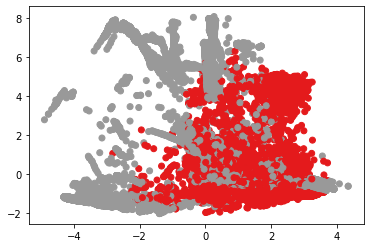

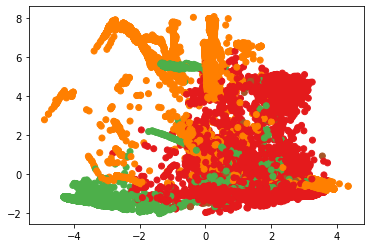

In [36]:
viz_train_data = np.array(pca_train_df.rdd.map(lambda row: [*row['pca_features'], row['labels2_index'], row['labels5_index']]).collect())
plt.figure()
plt.scatter(x=viz_train_data[:,0], y=viz_train_data[:,1], c=viz_train_data[:,2], cmap="Set1")
plt.figure()
plt.scatter(x=viz_train_data[:,0], y=viz_train_data[:,1], c=viz_train_data[:,3], cmap="Set1")
plt.show()

## KMeans clustering with Random Forest Classifiers

The idea of the first approach is to clusterize data into clusters and then train different Random Forest classifiers for each of the clusters. As Random Forest returns probabilities, it is possible to improve detection rate for a new types of attacks by adjusting threshold.

As KMeans cannot truly handle binary/categorical features only numeric features are used for clusterization.

In [37]:
kmeans_prob_col = 'kmeans_rf_prob'
kmeans_pred_col = 'kmeans_rf_pred'

prob_cols.append(kmeans_prob_col)
pred_cols.append(kmeans_pred_col)

In [38]:
# KMeans clustrering
from pyspark.ml.clustering import KMeans

kmeans_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features", 
                             names=list(set(selectFeaturesByAR(ar_dict, 0.1)).intersection(numeric_cols)))

kmeans = KMeans(k=8, initSteps=25, maxIter=100, featuresCol="features", predictionCol="cluster", seed=seed)

kmeans_pipeline = Pipeline(stages=[kmeans_slicer, kmeans])

kmeans_model = kmeans_pipeline.fit(scaled_train_df)

kmeans_train_df = kmeans_model.transform(scaled_train_df).cache()
kmeans_cv_df = kmeans_model.transform(scaled_cv_df).cache()
kmeans_test_df = kmeans_model.transform(scaled_test_df).cache()

In [39]:
# Function for describing the contents of the clusters 
def getClusterCrosstab(df, clusterCol='cluster'):
    return (df.crosstab(clusterCol, 'labels2')
              .withColumn('count', col('attack') + col('normal'))
              .withColumn(clusterCol + '_labels2', col(clusterCol + '_labels2').cast('int'))
              .sort(col(clusterCol +'_labels2').asc()))

In [40]:
kmeans_crosstab = getClusterCrosstab(kmeans_train_df).cache()
kmeans_crosstab.show(n=30)

+---------------+------+------+-----+
|cluster_labels2|attack|normal|count|
+---------------+------+------+-----+
|              0| 27850|   104|27954|
|              1|     0|     2|    2|
|              2|  3456|   482| 3938|
|              3|  1852|  2959| 4811|
|              4|   722|     0|  722|
|              5|    38|    55|   93|
|              6|  3375| 47911|51286|
|              7|  9820|  2242|12062|
+---------------+------+------+-----+



Clustres are splitted into two categories. Frist category contains clusters that have both 'attack' and 'normal' connections and have more than 25 connections. For the first category Random Forest classifiers are aplied. Second category contains all other clusters and maps cluster to 'attack' or 'normal' based on majority. All clusters that contains less or equal than 25 connections are treated as outliers and are mapped to 'attack' type.

In [41]:
# Function for splitting clusters
def splitClusters(crosstab):
    exp = ((col('count') > 25) & (col('attack') > 0) & (col('normal') > 0))

    cluster_rf = (crosstab
        .filter(exp).rdd
        .map(lambda row: (int(row['cluster_labels2']), [row['count'], row['attack']/row['count']]))
        .collectAsMap())

    cluster_mapping = (crosstab
        .filter(~exp).rdd
        .map(lambda row: (int(row['cluster_labels2']), 1.0 if (row['count'] <= 25) | (row['normal'] == 0) else 0.0))
        .collectAsMap())
    
    return cluster_rf, cluster_mapping

kmeans_cluster_rf, kmeans_cluster_mapping = splitClusters(kmeans_crosstab)

print(len(kmeans_cluster_rf), len(kmeans_cluster_mapping))
print(kmeans_cluster_mapping)
kmeans_cluster_rf

6 2
{1: 1.0, 4: 1.0}


{0: [27954, 0.9962796022036202],
 2: [3938, 0.877602844083291],
 3: [4811, 0.3849511536063189],
 5: [93, 0.40860215053763443],
 6: [51286, 0.06580743282767226],
 7: [12062, 0.8141270104460289]}

In [42]:
from pyspark.ml.classification import RandomForestClassifier

# This function returns Random Forest models for provided clusters
def getClusterModels(df, cluster_rf):
    cluster_models = {}

    labels_col = 'labels2_cl_index'
    labels2_indexer.setOutputCol(labels_col)

    rf_slicer = VectorSlicer(inputCol="indexed_features", outputCol="rf_features", 
                             names=selectFeaturesByAR(ar_dict, 0.05))

    for cluster in cluster_rf.keys():
        t1 = time()
        rf_classifier = RandomForestClassifier(labelCol=labels_col, featuresCol='rf_features', seed=seed,
                                               numTrees=500, maxDepth=20, featureSubsetStrategy="sqrt")
        
        rf_pipeline = Pipeline(stages=[labels2_indexer, rf_slicer, rf_classifier])
        cluster_models[cluster] = rf_pipeline.fit(df.filter(col('cluster') == cluster))
        print("Finished %g cluster in %g ms" % (cluster, time() - t1))
        
    return cluster_models

In [43]:
# This utility function helps to get predictions/probabilities for the new data and return them into one dataframe
def getProbabilities(df, probCol, cluster_mapping, cluster_models):
    pred_df = (sqlContext.createDataFrame([], StructType([
                    StructField('id', LongType(), False),
                    StructField(probCol, DoubleType(), False)])))
    
    udf_map = udf(lambda cluster: cluster_mapping[cluster], DoubleType())
    pred_df = pred_df.union(df.filter(col('cluster').isin(list(cluster_mapping.keys())))
                            .withColumn(probCol, udf_map(col('cluster')))
                            .select('id', probCol))

                                       
    for k in cluster_models.keys():
        maj_label = cluster_models[k].stages[0].labels[0]
        udf_remap_prob = udf(lambda row: float(row[0]) if (maj_label == 'attack') else float(row[1]), DoubleType())

        pred_df = pred_df.union(cluster_models[k]
                         .transform(df.filter(col('cluster') == k))
                         .withColumn(probCol, udf_remap_prob(col('probability')))
                         .select('id', probCol))

    return pred_df

In [44]:
# Training Random Forest classifiers for each of the clusters
kmeans_cluster_models = getClusterModels(kmeans_train_df, kmeans_cluster_rf)

Finished 0 cluster in 54.6705 ms
Finished 2 cluster in 25.383 ms
Finished 3 cluster in 8.22952 ms
Finished 5 cluster in 2.78168 ms
Finished 6 cluster in 598.828 ms
Finished 7 cluster in 70.6129 ms


In [45]:
# Getting probabilities for CV data
res_cv_df = (res_cv_df.drop(kmeans_prob_col)
             .join(getProbabilities(kmeans_cv_df, kmeans_prob_col, kmeans_cluster_mapping, kmeans_cluster_models), 'id')
             .cache())

print(res_cv_df.count())

25105


In [46]:
# Getting probabilities for Test data
res_test_df = (res_test_df.drop(kmeans_prob_col)
               .join(getProbabilities(kmeans_test_df, kmeans_prob_col, kmeans_cluster_mapping, kmeans_cluster_models), 'id')
               .cache())

print(res_test_df.count())

22544


As CV data is from the same distribution as the train data it isn't needed to adjust threshold.

In [46]:
printReport(res_cv_df, kmeans_prob_col, e=0.5, labels=labels2)

      	normal	attack	
normal	 13316	    12	
attack	    26	 11779	
 
Accuracy = 0.998488
AUC = 0.998449
 
False Alarm Rate = 0.00090036
Detection Rate = 0.997798
F1 score = 0.99839
 
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     13328
        1.0       1.00      1.00      1.00     11805

avg / total       1.00      1.00      1.00     25133

 


Because test data is from the different distribution and it is expected to face unseen attack types, it makes sence to adjust a probability threshold to something like 0.01 for attack connections (0.99 for normal connections). For this approach it gives around ~98-99% Detection Rate with around ~14-15% of False Alarm Rate.

In [47]:
printReport(res_test_df, kmeans_prob_col, e=0.01, labels=labels2)

      	normal	attack	
normal	  8262	  1449	
attack	   182	 12651	
 
Accuracy = 0.927653
AUC = 0.918303
 
False Alarm Rate = 0.149212
Detection Rate = 0.985818
F1 score = 0.939442
 
             precision    recall  f1-score   support

        0.0       0.98      0.85      0.91      9711
        1.0       0.90      0.99      0.94     12833

avg / total       0.93      0.93      0.93     22544

 


In [48]:
# Adding prediction columns based on chosen thresholds into result dataframes
t0 = time()
res_cv_df = res_cv_df.withColumn(kmeans_pred_col, getPrediction(0.5)(col(kmeans_prob_col))).cache()
res_test_df = res_test_df.withColumn(kmeans_pred_col, getPrediction(0.01)(col(kmeans_prob_col))).cache()

print(res_cv_df.count())
print(res_test_df.count())
print(time() - t0)

25133
22544
16.63809633255005


## Supervised approach for dettecting each type of attacks separately

The idea of the following approach is training Random Forest Classifiers for each of four major 'attack' categories separately.

### 1 DoS and normal

In [47]:
dos_prob_col = 'dos_prob'
dos_pred_col = 'dos_pred'

prob_cols.append(dos_prob_col)
pred_cols.append(dos_pred_col)

In [48]:
dos_exp = (col('labels5') == 'DoS') | (col('labels5') == 'normal')
dos_train_df = (scaled_train_df.filter(dos_exp).cache())

print(dos_train_df.count())
(dos_train_df
     .groupby('labels5')
     .count()
     .sort(sql.desc('count'))
     .show())

90625
+-------+-----+
|labels5|count|
+-------+-----+
| normal|53755|
|    DoS|36870|
+-------+-----+



Diffirent AR feature selection is used as only normal and DoS connections are treated. Note that train dataframe without standartization is used for getting Attribute Ratio dictionary.

In [49]:
dos_ar_dict = getAttributeRatio(train_df.filter(dos_exp), numeric_cols, binary_cols, 'labels5')
dos_ar_dict

OrderedDict([('flag_SF', 16.04886075949367),
             ('protocol_type_tcp', 11.283230810377106),
             ('flag_S0', 2.965034965034965),
             ('wrong_fragment', 2.4663052235068696),
             ('logged_in', 2.4559683875603),
             ('dst_host_srv_serror_rate', 2.4369460592635868),
             ('srv_serror_rate', 2.4091388710886803),
             ('serror_rate', 2.4030314967240214),
             ('dst_host_serror_rate', 2.400741230991562),
             ('count', 2.0805650842389314),
             ('rerror_rate', 1.729470874459903),
             ('srv_rerror_rate', 1.7274542811973752),
             ('dst_host_srv_rerror_rate', 1.7208022988464353),
             ('dst_host_rerror_rate', 1.720418433224073),
             ('num_failed_logins', 1.6819862494988345),
             ('num_root', 1.6819862494988345),
             ('urgent', 1.6819862494988342),
             ('num_file_creations', 1.6819862494988342),
             ('num_shells', 1.6819862494988342),
         

In [50]:
dos_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features", 
                          names=selectFeaturesByAR(dos_ar_dict, 0.05))

dos_rf = RandomForestClassifier(labelCol=labels_col, featuresCol='features', featureSubsetStrategy='sqrt',
                                numTrees=500, maxDepth=20, seed=seed)

dos_rf_pipeline = Pipeline(stages=[dos_slicer, dos_rf])
dos_rf_model = dos_rf_pipeline.fit(dos_train_df)

dos_cv_df = dos_rf_model.transform(scaled_cv_df).cache()
dos_test_df = dos_rf_model.transform(scaled_test_df).cache()
print(dos_cv_df.count())
print(dos_test_df.count())

25105
22544


In [51]:
# Getting probabilities for CV data
res_cv_df = (res_cv_df.drop(dos_prob_col)
             .join(dos_cv_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', dos_prob_col]),
                    'id')
                    .cache())

print(res_cv_df.count())

25105


In [52]:
# Getting probabilities for Test data
res_test_df = (res_test_df.drop(dos_prob_col)
               .join(dos_test_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', dos_prob_col]),
                    'id')
                    .cache())

print(res_test_df.count())

22544


The first report shows performance of classification for 'normal' and 'DoS' labels, the second report shows performance for the whole data with adjusted threshold.

In [53]:
printReport(res_cv_df.filter(dos_exp), probCol=dos_prob_col, e=0.5, labels=['normal', 'DoS'])
printReport(res_cv_df, probCol=dos_prob_col, e=0.05)

      	normal	   DoS	
normal	 13586	     2	
   DoS	     2	  9055	
 
Accuracy = 0.999823
AUC = 0.999816
 
False Alarm Rate = 0.000147189
Detection Rate = 0.999779
F1 score = 0.999779
 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13588
         1.0       1.00      1.00      1.00      9057

    accuracy                           1.00     22645
   macro avg       1.00      1.00      1.00     22645
weighted avg       1.00      1.00      1.00     22645

 
      	normal	attack	
normal	 13508	    80	
attack	   422	 11095	
 
Accuracy = 0.980004
AUC = 0.978735
 
False Alarm Rate = 0.00588755
Detection Rate = 0.963359
F1 score = 0.977878
 
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     13588
         1.0       0.99      0.96      0.98     11517

    accuracy                           0.98     25105
   macro avg       0.98      0.98      0.98     25105
weighted avg       0.98      0.9

In [54]:
printReport(res_test_df.filter(dos_exp), probCol=dos_prob_col, e=0.5, labels=['normal', 'DoS'])
printReport(res_test_df, probCol=dos_prob_col, e=0.01)

      	normal	   DoS	
normal	  9628	    83	
   DoS	  1621	  5837	
 
Accuracy = 0.900751
AUC = 0.887051
 
False Alarm Rate = 0.00854701
Detection Rate = 0.78265
F1 score = 0.872627
 
              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92      9711
         1.0       0.99      0.78      0.87      7458

    accuracy                           0.90     17169
   macro avg       0.92      0.89      0.90     17169
weighted avg       0.91      0.90      0.90     17169

 
      	normal	attack	
normal	  8733	   978	
attack	  2853	  9980	
 
Accuracy = 0.830066
AUC = 0.838486
 
False Alarm Rate = 0.100711
Detection Rate = 0.777683
F1 score = 0.838973
 
              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82      9711
         1.0       0.91      0.78      0.84     12833

    accuracy                           0.83     22544
   macro avg       0.83      0.84      0.83     22544
weighted avg       0.84      0.83   

In [55]:
# Adding prediction columns based on chosen thresholds into result dataframes
res_cv_df = res_cv_df.withColumn(dos_pred_col, getPrediction(0.05)(col(dos_prob_col))).cache()
res_test_df = res_test_df.withColumn(dos_pred_col, getPrediction(0.01)(col(dos_prob_col))).cache()

print(res_cv_df.count())
print(res_test_df.count())

25105
22544


### 2 Probe and normal

In [56]:
probe_prob_col = 'probe_prob'
probe_pred_col = 'probe_pred'

prob_cols.append(probe_prob_col)
pred_cols.append(probe_pred_col)

In [57]:
probe_exp = (col('labels5') == 'Probe') | (col('labels5') == 'normal')
probe_train_df = (scaled_train_df.filter(probe_exp).cache())

print(probe_train_df.count())
(probe_train_df
     .groupby('labels5')
     .count()
     .sort(sql.desc('count'))
     .show())

63157
+-------+-----+
|labels5|count|
+-------+-----+
| normal|53755|
|  Probe| 9402|
+-------+-----+



Diffirent AR feature selection is used as only normal and Probe connections are treated. Note that train dataframe without standartization is used for getting Attribute Ratio dictionary.

In [58]:
probe_ar_dict = getAttributeRatio(train_df.filter(probe_exp), numeric_cols, binary_cols, 'labels5')
probe_ar_dict

OrderedDict([('flag_SF', 16.04886075949367),
             ('dst_bytes', 5.954890189917854),
             ('src_bytes', 5.663342453521275),
             ('duration', 4.612329795738909),
             ('dst_host_diff_srv_rate', 4.295388446517403),
             ('srv_rerror_rate', 4.289248359824754),
             ('rerror_rate', 4.279060093009597),
             ('dst_host_srv_rerror_rate', 4.274560348159748),
             ('diff_srv_rate', 4.111925438331669),
             ('dst_host_rerror_rate', 4.008755744761221),
             ('protocol_type_tcp', 3.900167357927672),
             ('dst_host_srv_diff_host_rate', 3.7617643806475676),
             ('dst_host_srv_serror_rate', 3.589975516844939),
             ('dst_host_same_src_port_rate', 3.2601442474409343),
             ('serror_rate', 2.539265364386703),
             ('count', 2.520990695784333),
             ('srv_serror_rate', 2.4750624093482068),
             ('logged_in', 2.4559683875603),
             ('dst_host_serror_rate', 2.42

In [59]:
probe_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features",
                            names=selectFeaturesByAR(probe_ar_dict, 0.05))

probe_rf = RandomForestClassifier(labelCol=labels_col, featuresCol='features', featureSubsetStrategy='sqrt',
                                  numTrees=500, maxDepth=20, seed=seed)
probe_rf_pipeline = Pipeline(stages=[probe_slicer, probe_rf])

probe_rf_model = probe_rf_pipeline.fit(probe_train_df)

probe_cv_df = probe_rf_model.transform(scaled_cv_df).cache()
probe_test_df = probe_rf_model.transform(scaled_test_df).cache()

print(probe_cv_df.count())
print(probe_test_df.count())

25105
22544


In [60]:
# Getting probabilities for CV data
res_cv_df = (res_cv_df.drop(probe_prob_col)
             .join(probe_cv_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', probe_prob_col]), 'id')
                    .cache())

print(res_cv_df.count())

25105


In [61]:
# Getting probabilities for Test data
res_test_df = (res_test_df.drop(probe_prob_col)
               .join(probe_test_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', probe_prob_col]), 'id')
                    .cache())

print(res_test_df.count())

22544


The first report shows performance of classification for 'normal' and 'Probe' labels, the second report shows performance for the whole data with adjusted threshold.

In [62]:
printReport(res_cv_df.filter(probe_exp), probCol=probe_prob_col, e=0.5, labels=['normal', 'Probe'])
printReport(res_cv_df, probCol=probe_prob_col, e=0.05)

      	normal	 Probe	
normal	 13581	     7	
 Probe	    14	  2240	
 
Accuracy = 0.998674
AUC = 0.996637
 
False Alarm Rate = 0.00051516
Detection Rate = 0.993789
F1 score = 0.995334
 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13588
         1.0       1.00      0.99      1.00      2254

    accuracy                           1.00     15842
   macro avg       1.00      1.00      1.00     15842
weighted avg       1.00      1.00      1.00     15842

 
      	normal	attack	
normal	 13405	   183	
attack	   411	 11106	
 
Accuracy = 0.976339
AUC = 0.975423
 
False Alarm Rate = 0.0134678
Detection Rate = 0.964314
F1 score = 0.973954
 
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     13588
         1.0       0.98      0.96      0.97     11517

    accuracy                           0.98     25105
   macro avg       0.98      0.98      0.98     25105
weighted avg       0.98      0.98 

In [63]:
printReport(res_test_df.filter(probe_exp), probCol=probe_prob_col, e=0.5, labels=['normal', 'Probe'])
printReport(res_test_df, probCol=probe_prob_col, e=0.01)

      	normal	 Probe	
normal	  9489	   222	
 Probe	   905	  1516	
 
Accuracy = 0.907105
AUC = 0.801663
 
False Alarm Rate = 0.0228607
Detection Rate = 0.626188
F1 score = 0.729021
 
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94      9711
         1.0       0.87      0.63      0.73      2421

    accuracy                           0.91     12132
   macro avg       0.89      0.80      0.84     12132
weighted avg       0.90      0.91      0.90     12132

 
      	normal	attack	
normal	  8407	  1304	
attack	  1526	 11307	
 
Accuracy = 0.874468
AUC = 0.873404
 
False Alarm Rate = 0.134281
Detection Rate = 0.881088
F1 score = 0.888775
 
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86      9711
         1.0       0.90      0.88      0.89     12833

    accuracy                           0.87     22544
   macro avg       0.87      0.87      0.87     22544
weighted avg       0.87      0.87   

In [64]:
# Adding prediction columns based on chosen thresholds into result dataframes
res_cv_df = res_cv_df.withColumn(probe_pred_col, getPrediction(0.05)(col(probe_prob_col))).cache()
res_test_df = res_test_df.withColumn(probe_pred_col, getPrediction(0.01)(col(probe_prob_col))).cache()

print(res_cv_df.count())
print(res_test_df.count())

25105
22544


### 3 R2L, U2R and normal types

As there are a few examples of both R2L and U2R attack types and they have similar behaviour, they are combined into one group.

In [65]:
r2l_u2r_prob_col = 'r2l_u2r_prob'
r2l_u2r_pred_col = 'r2l_u2r_pred'

prob_cols.append(r2l_u2r_prob_col)
pred_cols.append(r2l_u2r_pred_col)

In [66]:
r2l_u2r_exp = (col('labels5') == 'R2L') | (col('labels5') == 'U2R') | (col('labels5') == 'normal')
r2l_u2r_train_df = (scaled_train_df.filter(r2l_u2r_exp).cache())

print(r2l_u2r_train_df.count())
(r2l_u2r_train_df
     .groupby('labels5')
     .count()
     .sort(sql.desc('count'))
     .show())

54596
+-------+-----+
|labels5|count|
+-------+-----+
| normal|53755|
|    R2L|  803|
|    U2R|   38|
+-------+-----+



Diffirent AR feature selection is used as only normal, R2L and U2R connections are treated. Note that train dataframe without standartization is used for getting Attribute Ratio dictionary.

In [67]:
r2l_u2r_ar_dict = getAttributeRatio(train_df.filter(r2l_u2r_exp), numeric_cols, binary_cols, 'labels5')
r2l_u2r_ar_dict

OrderedDict([('protocol_type_tcp', 1000.0),
             ('num_shells', 177.04511834319524),
             ('urgent', 93.9423076923077),
             ('flag_SF', 51.0),
             ('num_file_creations', 34.215028309254194),
             ('num_failed_logins', 25.660569514237856),
             ('hot', 23.850718086856727),
             ('src_bytes', 17.67531409051069),
             ('dst_bytes', 14.991946554922052),
             ('logged_in', 10.569767441860465),
             ('dst_host_same_src_port_rate', 4.628005391558456),
             ('duration', 3.6136716211332516),
             ('dst_host_srv_diff_host_rate', 3.1864996773281713),
             ('serror_rate', 2.833695081701005),
             ('dst_host_srv_serror_rate', 2.5500330660616055),
             ('num_access_files', 2.5488223017292784),
             ('num_compromised', 2.416504765066944),
             ('diff_srv_rate', 2.2340127157718115),
             ('service_telnet', 1.8888888888888888),
             ('dst_host_serror_

In [68]:
r2l_u2r_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features",
                              names=selectFeaturesByAR(r2l_u2r_ar_dict, 0.05))

r2l_u2r_rf = RandomForestClassifier(labelCol=labels_col, featuresCol='features', featureSubsetStrategy='sqrt',
                                    numTrees=500, maxDepth=20, seed=seed)
r2l_u2r_rf_pipeline = Pipeline(stages=[r2l_u2r_slicer, r2l_u2r_rf])

r2l_u2r_rf_model = r2l_u2r_rf_pipeline.fit(r2l_u2r_train_df)

r2l_u2r_cv_df = r2l_u2r_rf_model.transform(scaled_cv_df).cache()
r2l_u2r_test_df = r2l_u2r_rf_model.transform(scaled_test_df).cache()
print(r2l_u2r_cv_df.count())
print(r2l_u2r_test_df.count())

25105
22544


In [69]:
# Getting probabilities for CV data
res_cv_df = (res_cv_df.drop(r2l_u2r_prob_col)
             .join(r2l_u2r_cv_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', r2l_u2r_prob_col]), 'id')
                    .cache())

print(res_cv_df.count())

25105


In [70]:
# Getting probabilities for Test data
res_test_df = (res_test_df.drop(r2l_u2r_prob_col)
               .join(r2l_u2r_test_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', r2l_u2r_prob_col]), 'id')
                    .cache())

print(res_test_df.count())

22544


The first report shows performance of classification for 'normal' and 'R2L&U2R' labels, the second report shows performance for the whole data with adjusted threshold.

In [71]:
printReport(res_cv_df.filter(r2l_u2r_exp), probCol=r2l_u2r_prob_col, e=0.5, labels=['normal', 'R2L&U2R'])
printReport(res_cv_df, probCol=r2l_u2r_prob_col, e=0.05, labels=labels2)

       	 normal	R2L&U2R	
 normal	  13588	      0	
R2L&U2R	     15	    191	
 
Accuracy = 0.998913
AUC = 0.963592
 
False Alarm Rate = 0
Detection Rate = 0.927184
F1 score = 0.962217
 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13588
         1.0       1.00      0.93      0.96       206

    accuracy                           1.00     13794
   macro avg       1.00      0.96      0.98     13794
weighted avg       1.00      1.00      1.00     13794

 
      	normal	attack	
normal	 13516	    72	
attack	  4378	  7139	
 
Accuracy = 0.822744
AUC = 0.807284
 
False Alarm Rate = 0.00529879
Detection Rate = 0.619866
F1 score = 0.762388
 
              precision    recall  f1-score   support

         0.0       0.76      0.99      0.86     13588
         1.0       0.99      0.62      0.76     11517

    accuracy                           0.82     25105
   macro avg       0.87      0.81      0.81     25105
weighted avg       0.86      0.82

In [72]:
printReport(res_test_df.filter(r2l_u2r_exp), probCol=r2l_u2r_prob_col, e=0.5, labels=['normal', 'R2L&U2R'])
printReport(res_test_df, probCol=r2l_u2r_prob_col, e=0.01, labels=labels2)

       	 normal	R2L&U2R	
 normal	   9710	      1	
R2L&U2R	   2656	    298	
 
Accuracy = 0.790209
AUC = 0.550389
 
False Alarm Rate = 0.000102976
Detection Rate = 0.10088
F1 score = 0.183215
 
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88      9711
         1.0       1.00      0.10      0.18      2954

    accuracy                           0.79     12665
   macro avg       0.89      0.55      0.53     12665
weighted avg       0.83      0.79      0.72     12665

 
      	normal	attack	
normal	  9365	   346	
attack	  5972	  6861	
 
Accuracy = 0.719748
AUC = 0.749504
 
False Alarm Rate = 0.0356297
Detection Rate = 0.534637
F1 score = 0.684731
 
              precision    recall  f1-score   support

         0.0       0.61      0.96      0.75      9711
         1.0       0.95      0.53      0.68     12833

    accuracy                           0.72     22544
   macro avg       0.78      0.75      0.72     22544
weighted avg       0.80  

In [73]:
# Adding prediction columns based on chosen thresholds into result dataframes
res_cv_df = res_cv_df.withColumn(r2l_u2r_pred_col, getPrediction(0.05)(col(r2l_u2r_prob_col))).cache()
res_test_df = res_test_df.withColumn(r2l_u2r_pred_col, getPrediction(0.01)(col(r2l_u2r_prob_col))).cache()

print(res_cv_df.count())
print(res_test_df.count())

25105
22544


### Combining results

In [74]:
sup_prob_col = 'sup_prob'
sup_pred_col = 'sup_pred'

prob_cols.append(sup_prob_col)
pred_cols.append(sup_pred_col)

In [76]:
res_cv_df = res_cv_df.withColumn(sup_prob_col, 
                                 (col(dos_prob_col) + col(probe_prob_col) + col(r2l_u2r_prob_col))/3).cache()

printReport(res_cv_df, sup_prob_col, e=0.05, labels=labels2)

      	normal	attack	
normal	 13463	   125	
attack	     7	 11510	
 
Accuracy = 0.994742
AUC = 0.995096
 
False Alarm Rate = 0.00919929
Detection Rate = 0.999392
F1 score = 0.994299
 
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     13588
         1.0       0.99      1.00      0.99     11517

    accuracy                           0.99     25105
   macro avg       0.99      1.00      0.99     25105
weighted avg       0.99      0.99      0.99     25105

 


In [77]:
res_cv_df = res_cv_df.withColumn(sup_pred_col, col(dos_pred_col).cast('int')
                                        .bitwiseOR(col(probe_pred_col).cast('int'))
                                        .bitwiseOR(col(r2l_u2r_pred_col).cast('int'))).cache()

printReport(res_cv_df, sup_pred_col, labels=labels2)

      	normal	attack	
normal	 13299	   289	
attack	     1	 11516	
 
Accuracy = 0.988449
AUC = 0.989322
 
False Alarm Rate = 0.0212688
Detection Rate = 0.999913
F1 score = 0.987565
 
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     13588
         1.0       0.98      1.00      0.99     11517

    accuracy                           0.99     25105
   macro avg       0.99      0.99      0.99     25105
weighted avg       0.99      0.99      0.99     25105

 


In [78]:
res_test_df = res_test_df.withColumn(sup_prob_col, 
                                 (col(dos_prob_col) + col(probe_prob_col) + col(r2l_u2r_prob_col))/3).cache()

printReport(res_test_df, sup_prob_col, e=0.005, labels=labels2)

      	normal	attack	
normal	  8370	  1341	
attack	   629	 12204	
 
Accuracy = 0.912615
AUC = 0.906447
 
False Alarm Rate = 0.138091
Detection Rate = 0.950986
F1 score = 0.925317
 
              precision    recall  f1-score   support

         0.0       0.93      0.86      0.89      9711
         1.0       0.90      0.95      0.93     12833

    accuracy                           0.91     22544
   macro avg       0.92      0.91      0.91     22544
weighted avg       0.91      0.91      0.91     22544

 


In [79]:
res_test_df = res_test_df.withColumn(sup_pred_col, col(dos_pred_col).cast('int')
                                            .bitwiseOR(col(probe_pred_col).cast('int'))
                                            .bitwiseOR(col(r2l_u2r_pred_col).cast('int'))).cache()

printReport(res_test_df, sup_pred_col, labels=labels2)

      	normal	attack	
normal	  8285	  1426	
attack	   346	 12487	
 
Accuracy = 0.921398
AUC = 0.913097
 
False Alarm Rate = 0.146844
Detection Rate = 0.973038
F1 score = 0.933747
 
              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90      9711
         1.0       0.90      0.97      0.93     12833

    accuracy                           0.92     22544
   macro avg       0.93      0.91      0.92     22544
weighted avg       0.92      0.92      0.92     22544

 
